# Locus Importance Scores

Importance score plots at a locus across cell states.

**Inputs**: 
1. Config:
    - For each cluster, colour, description, new cluster number (set to same as original if it should not be changed)
2. Bigwig files with importance scores per cluster.
3. Gene annotation
4. Set of peak regions to compute per track stats e.g. quantiles.

In [1]:
library(ggplot2)
library(ggseqlogo)
library(GenomicRanges)
library(patchwork)
library(rtracklayer)
library(rhdf5)

library(BSgenome.Hsapiens.UCSC.hg38)
library(zoo)

hg38 = BSgenome.Hsapiens.UCSC.hg38

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The

In [2]:
DAYS = c("D0", "D2", "D4", "D6", "D8", "D10", "D12", "D14", "iPSC")

## Loading Inputs

### Day and Cluster Configs

In [3]:
day_config = read.table("./configs/day.tsv", comment.char = '', header=T)
day_config$colour = as.character(day_config$colour)
day_config$day = factor(day_config$day, levels=DAYS)
rownames(day_config) = day_config$day
day_config

,day,colour
,<fct>,<chr>
D0,D0,#A61C24
D2,D2,#FF70A6
D4,D4,#D6E82F
D6,D6,#B14AED
D8,D8,#2D3142
D10,D10,#FC7753
D12,D12,#0AABB7
D14,D14,#336699
iPSC,iPSC,#13C4A3


In [4]:
cluster_config = read.table("./configs/cluster.tsv", comment.char = '', header=T, sep='\t')
cluster_config$colour = as.character(cluster_config$colour)
cluster_config$description = as.character(cluster_config$description)

# print friendly
cluster_config[9, "description"] = "Partially\nreprogrammed"

cluster_config = cluster_config[!is.na(cluster_config$cluster), ]
rownames(cluster_config) = as.factor(cluster_config$cluster)
cluster_config$new_cluster = as.integer(cluster_config$new_cluster)
cluster_config$cluster = as.integer(cluster_config$cluster)
cluster_config

,cluster,colour,description,new_cluster
,<int>,<chr>,<chr>,<int>
1,1,#B03743,Fibroblast,1
2,2,#E85F6D,Fibroblast-like,3
3,3,#7C2730,Fibroblast-like,2
4,4,#F0A118,Intermediate,12
5,5,#78A824,Pre-iPSC,13
6,6,#A6D854,Pre-iPSC,14
7,7,#F01D35,Fibroblast-like,5
8,8,#13C4A3,iPSC,15
9,9,#406614,Partially reprogrammed,10


### Gene Model

In [5]:
gencode.basic.hg38 = import.gff(gzfile("../../resources/GENCODE/gencode.v33.chr_patch_hapl_scaff.basic.annotation.gtf.gz"))
gencode.basic.hg38 = keepStandardChromosomes(gencode.basic.hg38, pruning.mode = "coarse")
gene_anno <- data.frame(gencode.basic.hg38)
gene_anno = gene_anno[!is.na(gene_anno$exon_number), ]
gene_anno = gene_anno[gene_anno$gene_type=="protein_coding", ]

# rename some columns to match requirements
gene_anno$chromosome <-  gene_anno$seqnames
gene_anno$gene <- gene_anno$gene_id
gene_anno$transcript <- gene_anno$transcript_name
gene_anno$symbol <- gene_anno$gene_name

gene_anno$feature = as.character(gene_anno$type)
gene_anno$exon = gene_anno$exon_id
gene_anno = gene_anno[,c("chromosome", "start", "end", "strand", "gene", "symbol", "transcript", "feature", "exon")]
head(gene_anno)

Warning message in readGFF(filepath, version = version, filter = filter):
“connection is not positioned at the start of the file, rewinding it”


,chromosome,start,end,strand,gene,symbol,transcript,feature,exon
,<fct>,<int>,<int>,<fct>,<chr>,<chr>,<chr>,<chr>,<chr>
57,chr1,65419,65433,+,ENSG00000186092.6,OR4F5,OR4F5-202,exon,ENSE00003812156.1
58,chr1,65520,65573,+,ENSG00000186092.6,OR4F5,OR4F5-202,exon,ENSE00003813641.1
59,chr1,65565,65573,+,ENSG00000186092.6,OR4F5,OR4F5-202,CDS,ENSE00003813641.1
60,chr1,65565,65567,+,ENSG00000186092.6,OR4F5,OR4F5-202,start_codon,ENSE00003813641.1
61,chr1,69037,71585,+,ENSG00000186092.6,OR4F5,OR4F5-202,exon,ENSE00003813949.1
62,chr1,69037,70005,+,ENSG00000186092.6,OR4F5,OR4F5-202,CDS,ENSE00003813949.1


### Importance Score BigWigs + Regions

In [6]:
IMP_BIGWIGS = "/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx%d/interpret/bigwig/counts.importance.bw"
CLUSTERS = seq(15)

BIGWIG_PATHS = list()

for (i in CLUSTERS) {
    BIGWIG_PATHS[[i]] = sprintf(IMP_BIGWIGS, i)
}

head(BIGWIG_PATHS)

[[1]]
[1] "/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx1/interpret/bigwig/counts.importance.bw"

[[2]]
[1] "/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx2/interpret/bigwig/counts.importance.bw"

[[3]]
[1] "/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx3/interpret/bigwig/counts.importance.bw"

[[4]]
[1] "/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx4/interpret/bigwig/counts.importance.bw"

[[5]]
[1] "/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx5/interpret/bigwig/counts.importance.bw"

[[6]]
[1] "/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx6/interpret/bigwig/counts.importance.bw"

In [7]:
PRED_BIGWIGS = "/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx%d/predict/cluster_idx%d_wo_bias.bw"

PRED_PATHS = list()

for (i in CLUSTERS) {
    PRED_PATHS[[i]] = sprintf(PRED_BIGWIGS, i, i)
}

head(PRED_PATHS)

[[1]]
[1] "/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx1/predict/cluster_idx1_wo_bias.bw"

[[2]]
[1] "/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx2/predict/cluster_idx2_wo_bias.bw"

[[3]]
[1] "/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx3/predict/cluster_idx3_wo_bias.bw"

[[4]]
[1] "/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx4/predict/cluster_idx4_wo_bias.bw"

[[5]]
[1] "/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx5/predict/cluster_idx5_wo_bias.bw"

[[6]]
[1] "/oak/stanford/groups/akundaje/surag/projects/scATAC-reprog/bpnet/models/20210820_chrombpnet_lite/chrombpnet/cluster_idx6/predict/cluster_idx6_wo_bias.bw"

### All Peaks

In [8]:
all_peaks = read.table("../analysis/20200122_snapATAC/snapATAC_sessions/20210714_n64913/peaks/overlap.peaks.resolved.500.bed")[,1:3]
colnames(all_peaks) = c("chr", "start", "end")
all_peaks = GRanges(all_peaks)

In [9]:
unique(width(all_peaks))

[1] 501

In [10]:
all_peaks = sort(all_peaks)
all_peaks

GRanges object with 531538 ranges and 0 metadata columns:
           seqnames            ranges strand
              <Rle>         <IRanges>  <Rle>
       [1]     chr1        9927-10427      *
       [2]     chr1       11135-11635      *
       [3]     chr1       13270-13770      *
       [4]     chr1       15429-15929      *
       [5]     chr1       15990-16490      *
       ...      ...               ...    ...
  [531534]     chrY 56833017-56833517      *
  [531535]     chrY 56838791-56839291      *
  [531536]     chrY 56842218-56842718      *
  [531537]     chrY 56846943-56847443      *
  [531538]     chrY 56850572-56851072      *
  -------
  seqinfo: 24 sequences from an unspecified genome; no seqlengths

## Processing

In [11]:
# one bigwig at a time, any number of peaks
get_matrix_from_bigwig <- function(bigwig_path, peak_set) {
    # ensure peak set has fixed width
    stopifnot(length(unique(width(peak_set)))==1)
    
    as.matrix(import(bigwig_path, 
      which=peak_set, as="NumericList"))
}

In [12]:
# calculate top and bottom percentiles for imp for each state

upper_lims = list()
lower_lims = list()

NUM_SAMP = 1000

sampled_peaks = sample(all_peaks, NUM_SAMP)
for (i in CLUSTERS) {
    
    vals = as.vector(get_matrix_from_bigwig(BIGWIG_PATHS[[i]], resize(sampled_peaks, width=500, fix='center')))
    
    upper_lims[[i]] = quantile(vals, 0.999)
    lower_lims[[i]] = quantile(vals, 0.001)
}

In [13]:
# calculate top percentiles for preds for each state

pred_upper_lims = list()

NUM_SAMP = 1000

sampled_peaks = sample(all_peaks, NUM_SAMP)
for (i in CLUSTERS) {
    
    vals = as.vector(get_matrix_from_bigwig(PRED_PATHS[[i]], resize(sampled_peaks, width=500, fix='center')))
    
    pred_upper_lims[[i]] = quantile(vals, 0.999)
}

## Plotting

In [14]:
# many bigwigs, one peak
get_importance_from_bigwigs <- function(clusters, bigwig_paths, peak) {
    # get DNA sequence
    sequence = hg38[[as.vector(seqnames(peak))]][start(peak):end(peak)]
    
    scores = list()
    
    for (i in clusters) {
        m = matrix(0, length(sequence), 4)
        colnames(m) = c("A", "C", "G", "T")
        m[cbind(seq(length(sequence)), as.vector(matrix(sequence)))] = get_matrix_from_bigwig(bigwig_paths[[i]], peak)
        
        scores[[i]] = t(m)
    }
    
    scores
}

In [15]:
# many bigwigs, one peak
get_preds_from_bigwigs <- function(clusters, bigwig_paths, peak) {
    preds = list()
    
    for (i in clusters) {
        preds[[i]] = as.vector(get_matrix_from_bigwig(bigwig_paths[[i]], peak))
    }
    
    preds
}

In [16]:
plot_seq <- function(m, ymin, ymax, clip=F, cutrange=NULL) {
    mat = m
    
#     rownames(mat) = c("A", "C", "G", "T")
    
    # cap to upper and lower limits
    if (clip==T) {
        mat[mat>ymax] = ymax
        mat[mat<ymin] = ymin
    }
    
    # mod_pred = pred
#     mod_pred[mod_pred>pred_max] = pred_max
    #mod_pred = mod_pred/max(mod_pred)*ymax
#     mod_pred = (mod_pred/pred_max)*ymax
    
    if (length(cutrange) == 0) {
        p = ggplot() #data.frame(x=seq(ncol(mat)), y=mod_pred)) + geom_line(aes(x=x,y=y), alpha=0.2) 
        p = p + geom_logo(mat, method='custom', seq_type='dna') 
    }
    
    else {
        # untested
        p = ggplot() #data.frame(x=seq(cutrange[2]-cutrange[1]), y=mod_pred[cutrange])) + geom_line(aes(x=x,y=y), alpha=0.2)
        p = p + geom_logo(mat[,cutrange], method='custom', seq_type='dna') 
    }
    
    p = p + theme_void() + coord_cartesian(ylim=c(ymin, ymax))
    
    p
}

In [17]:
plot_imp_across_tasks <- function(peak, clip=T, cutrange=NULL) {
    # extracts importance scores for region from all clusters (if available)
    imp_scores_plots = c()
    
    imp_scores = get_importance_from_bigwigs(CLUSTERS, BIGWIG_PATHS, peak) 
#    preds = get_preds_from_bigwigs(CLUSTERS, PRED_PATHS, peak)
                               
    for (i in CLUSTERS) {
        if (sum(imp_scores[[i]])!=0) {
            imp_scores_plots[[i]] = plot_seq(imp_scores[[i]],
                                        lower_lims[[i]], 
                                        upper_lims[[i]],
 #                                       preds[[i]],
  #                                      pred_upper_lims[[i]],
                                        clip=clip, 
                                        cutrange=cutrange)
        }
        else {
            imp_scores_plots[[i]] = ggplot() + theme_void() #plot_spacer()
        }
    }
    
    imp_scores_plots
}

In [69]:
options(repr.plot.width = 5, repr.plot.height = 24)

get_cluster_cbar <- function(subset=NULL) {
    
    cluster_config_selected = cluster_config[as.character(CLUSTERS),]
    
    if (!is.null(subset)) {
        cluster_config_selected = cluster_config_selected[cluster_config_selected$new_cluster %in% subset, ]
    }
    
    
    # cluster_config_selected$y = factor(paste(cluster_config_selected$new_cluster, cluster_config_selected$description, sep=' - '))
    cluster_config_selected$y = factor(cluster_config_selected$new_cluster)
    levels(cluster_config_selected$y) = cluster_config_selected$y[rev(order(cluster_config_selected$new_cluster))]

    cluster_colourbar <- ggplot(cluster_config_selected, 
                                aes(x=1, 
                                y=y, 
                                fill = y, 
                                label= new_cluster)) +
      geom_bar(stat="identity") +
    #   ylab("scRNA Cell State") +
      theme_void() +
      scale_fill_manual(values = as.character(cluster_config_selected$colour[rev(order(cluster_config_selected$new_cluster))])) +
      theme(legend.position = 'none',
    #         axis.text.y = element_text(size=26, margin=margin(t=10, r= -150))
    #         axis.title.y = element_text(size=20, angle=90, margin=margin(t=10))
           ) # adjust this to match heights

    for (i in seq(nrow(cluster_config_selected))) {
        cluster_colourbar = cluster_colourbar + annotate("text", x=0.5, y=i, 
                                                         label=levels(cluster_config_selected$y)[i], 
                                                         color="white",
                                                        size=4)
    }
    
    cluster_colourbar
}


In [70]:
cluster_colourbar = get_cluster_cbar()

In [31]:
# options(repr.plot.width = 1, repr.plot.height = 10)
# cluster_colourbar

In [32]:
# plot_motif_track <- function(peak) {
#     motifs_in_frame = motif_annotation[queryHits(findOverlaps(motif_annotation, peak))]
#     p = ggplot() + annotate("point", x=1, y=1) + annotate("point", x=end(peak)-start(peak), y=1)
    
#     if (length(motifs_in_frame)==0) {
#         p = plot_spacer()
#     }
    
#     else {
        
#         for (i in seq(length(motifs_in_frame))) {
#             cur_motif = motifs_in_frame[i]

#             p = p + annotate("rect", 
#                              xmin=max(0,start(cur_motif)-start(peak)+2),
#                              xmax=min(end(cur_motif)-start(peak)+2, end(cur_motif)),
#                              ymin=0, ymax=1, color="black", fill="white") +
#                     annotate("text",
#                              x=((start(cur_motif)+end(cur_motif))/2-start(peak)+2),
#                              y = 0.5, label=as.character(cur_motif$motif), color="black", size=10)
#         }
#     }
    
#     p + theme_void()
# }

In [32]:
plot_peak <- function(peak, clip=T, cutrange=NULL, subset=NULL) {
    imp_plot = plot_imp_across_tasks(peak, clip, cutrange)

    if (!is.null(subset)) {
        subsetted_clusters = CLUSTERS[cluster_config[as.character(CLUSTERS), "new_cluster"] %in% subset]
    }
    else {
        subsetted_clusters = CLUSTERS
    }

    
    imp_plot = imp_plot[subsetted_clusters[order(cluster_config[as.character(subsetted_clusters), "new_cluster"])]]

    
#     motif_track = plot_motif_track(peak)
    p = wrap_plots(imp_plot, ncol=1)
    
#     p = wrap_plots(p,
#                    wrap_plots(plot_spacer(), motif_track, widths=width_ratios),
#                    heights=c(length(imp_plot), 0.5))
    p #+ plot_annotation(title = as.character(peak),
#                                    theme= theme(plot.title = element_text(size = 36)))
}

In [34]:
peak = resize(GRanges("chr12:7758321-7758665"), width=350, fix="center")
# peak = GRanges("chr19:44906601-44906616")

In [35]:
as.character(peak) 

[1] "chr12:7758318-7758667"

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which wi

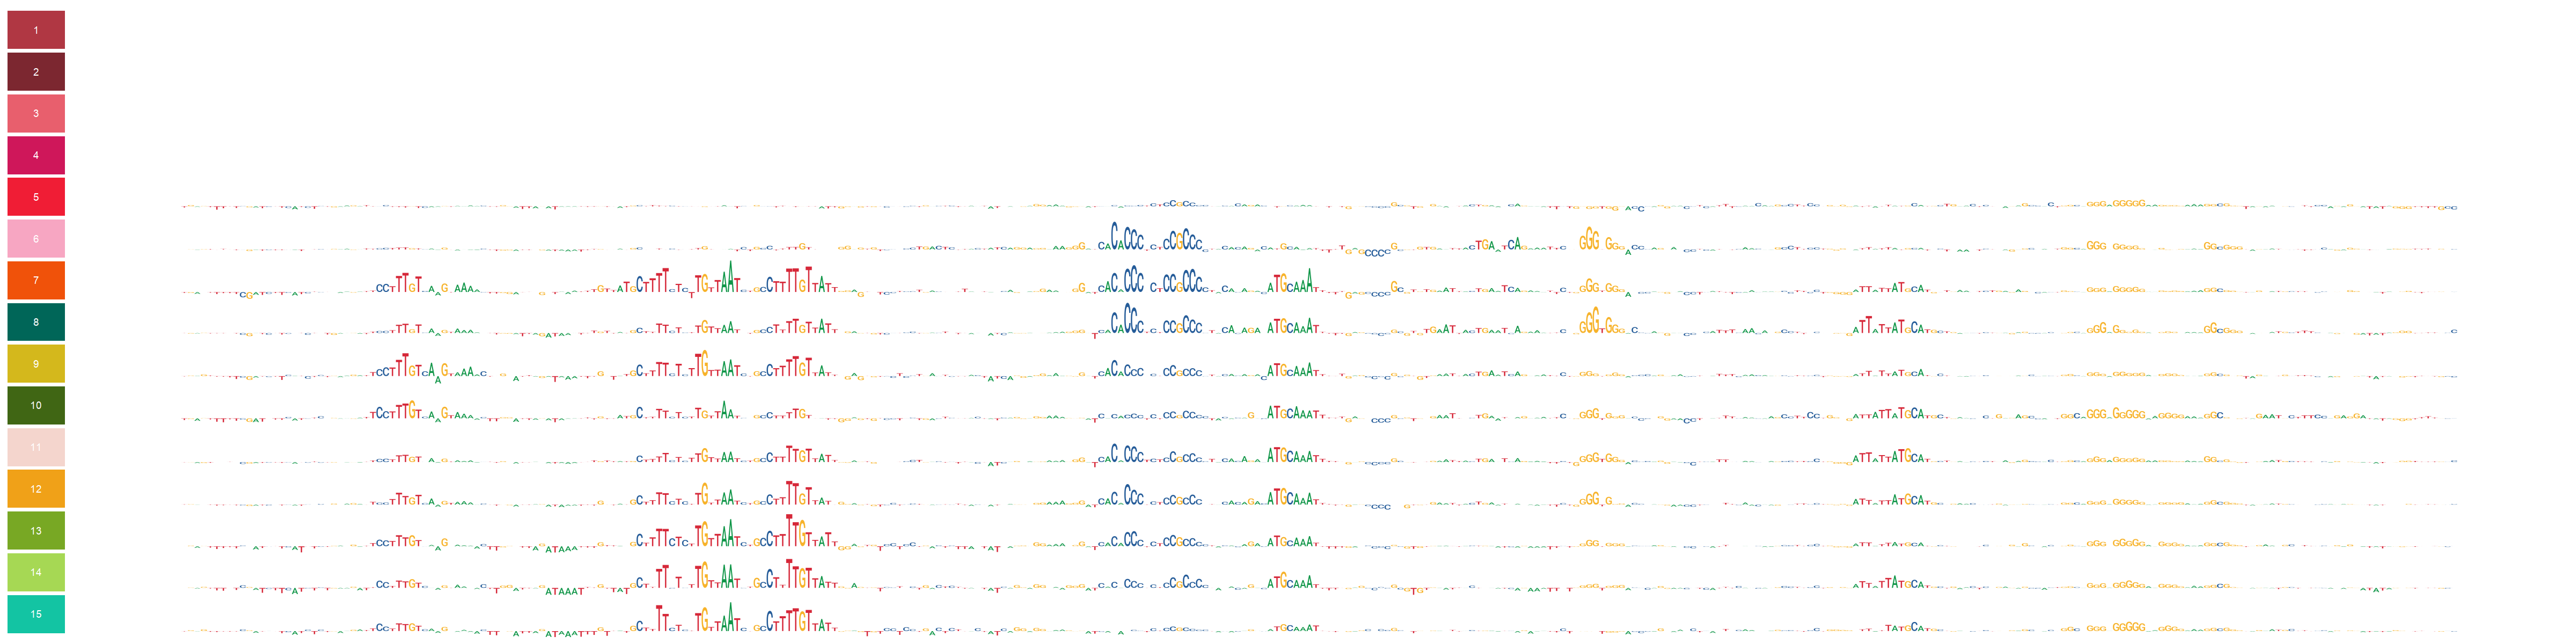

In [36]:
options(repr.plot.width = 40, repr.plot.height = 10)

p <- plot_peak(peak) 

p <- wrap_plots(cluster_colourbar,
           p,
           widths=c(1,40))

p

## Figure 6

In [50]:
LEFT_CTCF_RG = "chr12:7638839-7638877"
left_ctcf = GRanges(LEFT_CTCF_RG)

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which wi

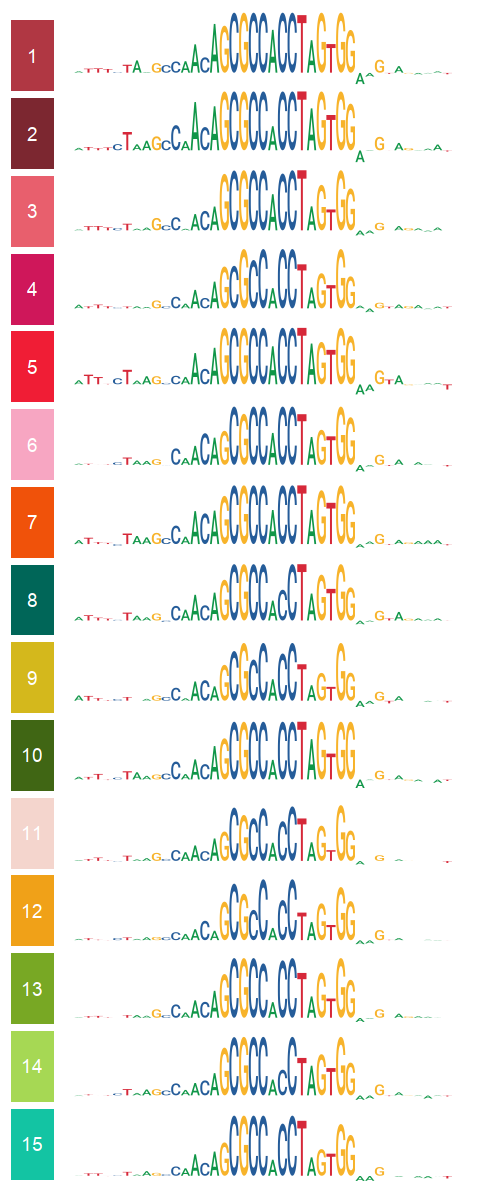

In [51]:
options(repr.plot.width = 4, repr.plot.height = 10)

p <- plot_peak(left_ctcf)

p <- wrap_plots(cluster_colourbar,
                p,
           widths=c(1,9))

p

In [52]:
ggsave(sprintf("./Fig6/subfigs/Left_CTCF_%s.pdf", LEFT_CTCF_RG), height=10, width=4, useDingbats=F)

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which wi

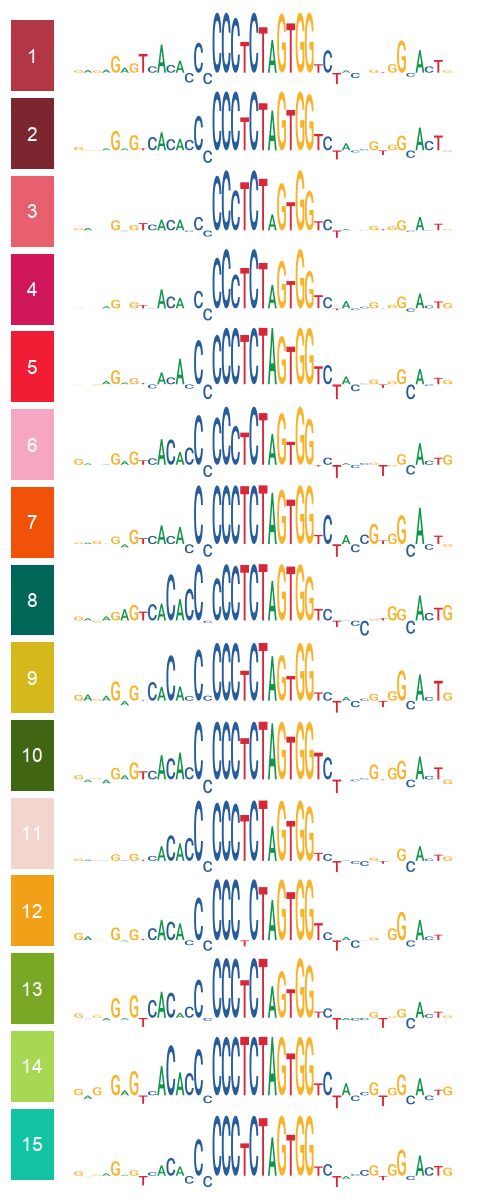

In [59]:
options(repr.plot.width = 4, repr.plot.height = 10)

RIGHT_CTCF_RG = "chr12:7807035-7807075"
right_ctcf = GRanges(RIGHT_CTCF_RG)

p <- plot_peak(right_ctcf)

p <- wrap_plots(cluster_colourbar,
                p,
           widths=c(1,9))

p

In [60]:
ggsave(sprintf("./Fig6/subfigs/Right_CTCF_%s.pdf", RIGHT_CTCF_RG), height=10, width=4, useDingbats=F)

In [61]:
NANOG_ENH_RG = "chr12:7758383-7758497"
nanog_enh = GRanges(NANOG_ENH_RG)
p1 <- plot_peak(nanog_enh)

NANOG_PROM_RG = "chr12:7789247-7789308"
nanog_prom = GRanges(NANOG_PROM_RG)
p2 <- plot_peak(nanog_prom)

DPPA_CTCF_RG = "chr12:7716552-7716611"
dppa_ctcf = GRanges(DPPA_CTCF_RG)
p3 <- plot_peak(dppa_ctcf)

bottom = wrap_plots(cluster_colourbar,
           p3,
           p1,
           p2,
          widths=c(4,width(dppa_ctcf),width(nanog_enh), width(nanog_prom)))

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which wi

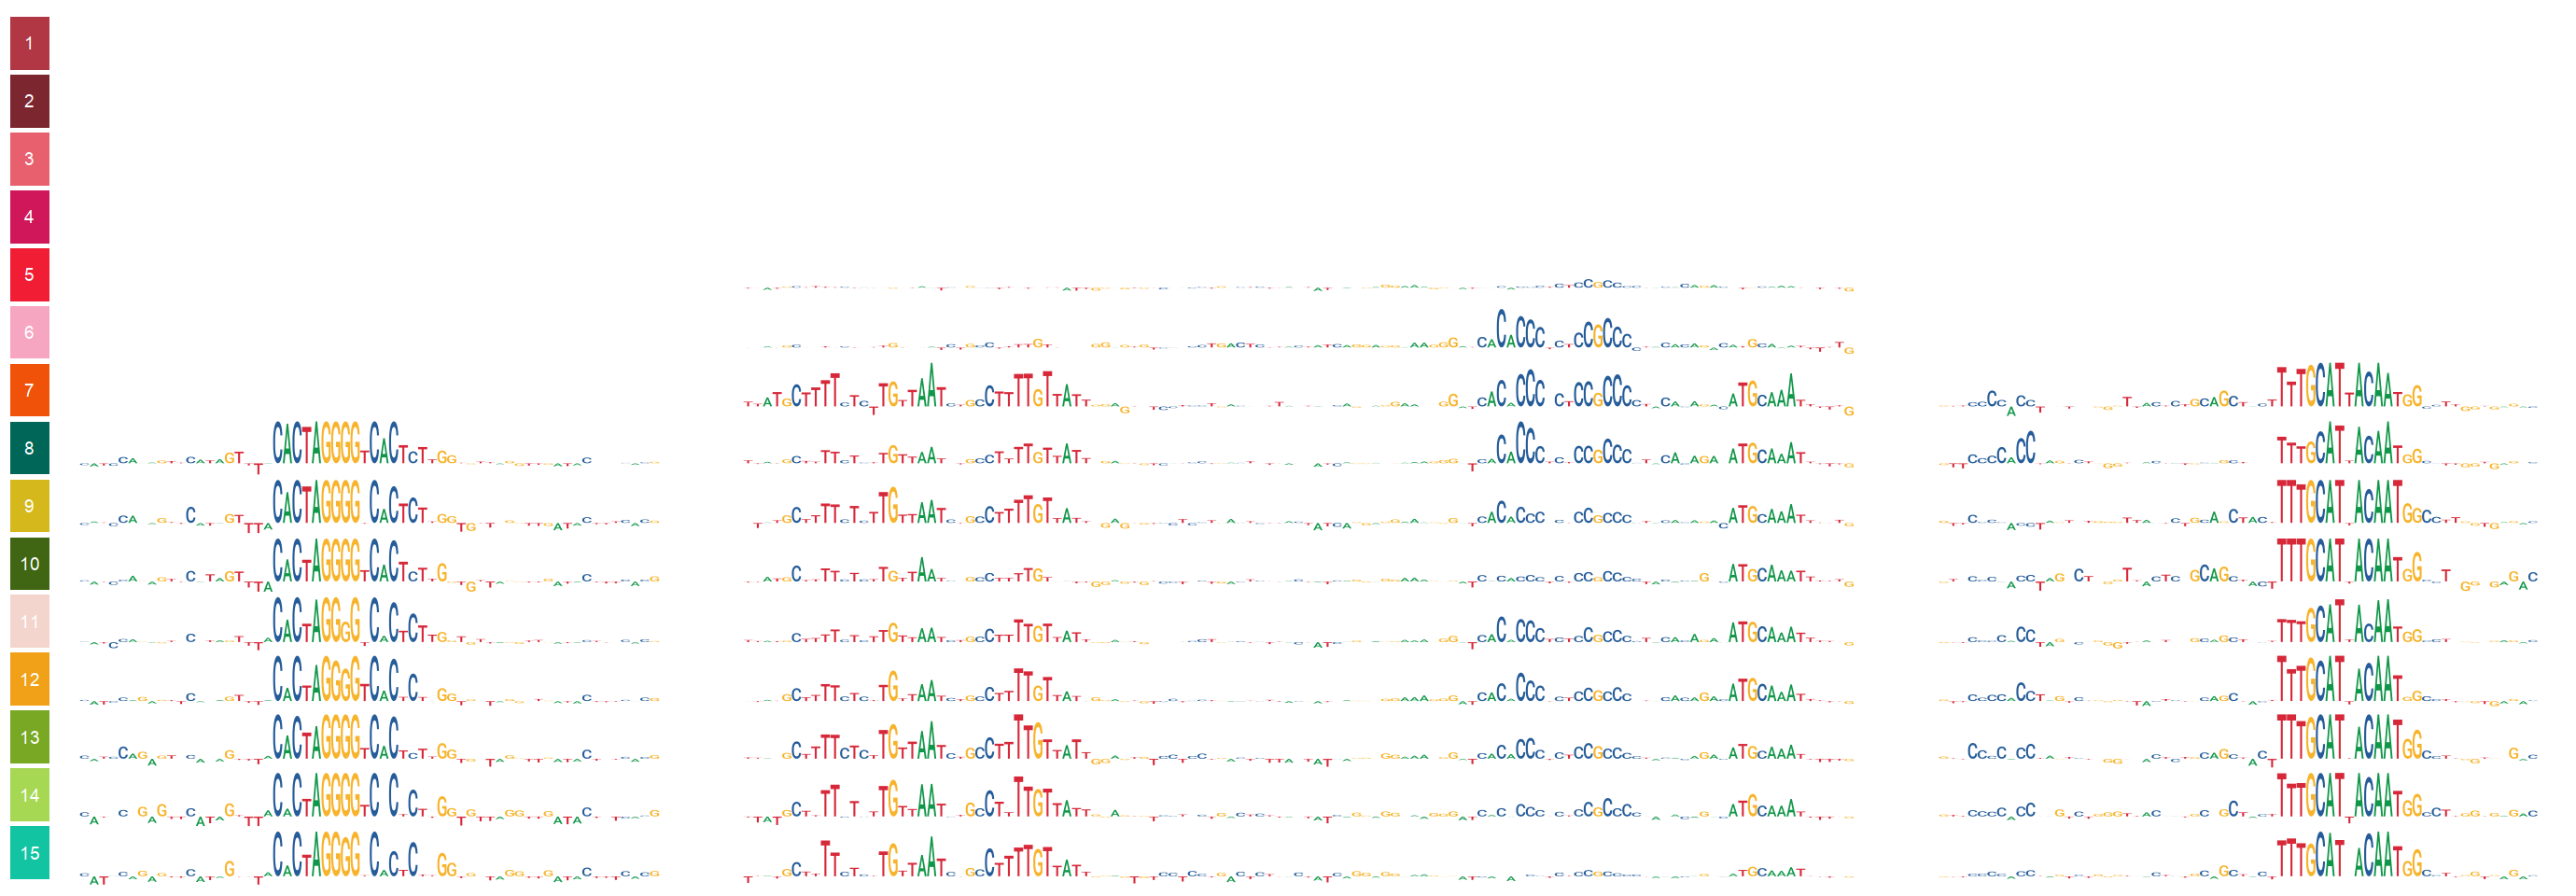

In [62]:
options(repr.plot.width = 23, repr.plot.height = 8)
bottom

In [63]:
ggsave(sprintf("./Fig6/subfigs/multi_%s_%s_%s.pdf", DPPA_CTCF_RG, NANOG_ENH_RG, NANOG_PROM_RG), height=8, width=23, useDingbats=F)

## Transient/ON Peaks Peaks

In [91]:
SUBSET = c(1,8,11,12,13,14,15)

In [103]:
T1 = "chr12:44034747-44034859" # p8
trans1 = GRanges(T1)
p1 <- plot_peak(trans1, subset=SUBSET)

T2 = "chr18:770621-770700" # p12
trans2 = GRanges(T2)
p2 <- plot_peak(trans2, subset=SUBSET)

O1 = "chr5:70089132-70089243" # p14
on1 = GRanges(O1)
p3 <- plot_peak(on1, subset=SUBSET)

bottom = wrap_plots(get_cluster_cbar(SUBSET),
           p1,
           p2,
           p3,
          widths=c(10,width(trans1),width(trans2), width(on1)))

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which will replace the existing one.

Coordinate system already present. Adding new coordinate system, which wi

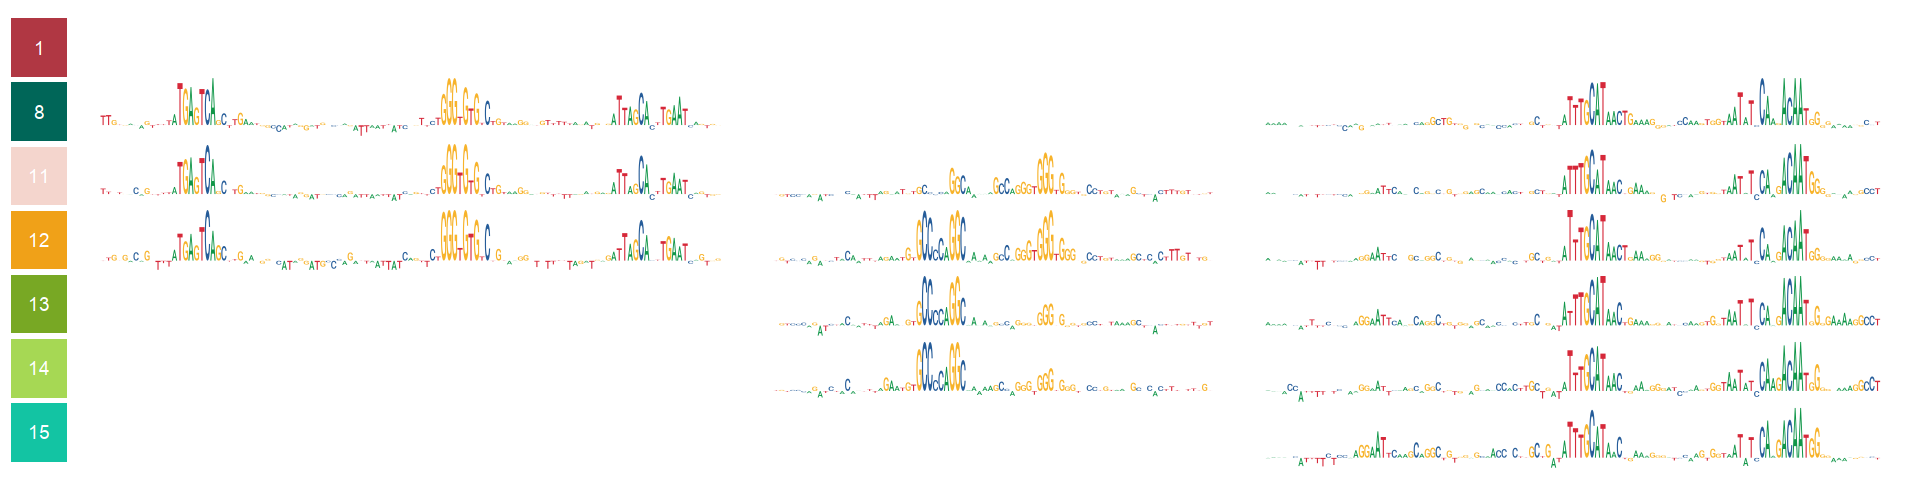

In [104]:
options(repr.plot.width = 16, repr.plot.height = 4)
bottom

In [108]:
ggsave(sprintf("./Fig3/subfigs/trans_on_%s_%s_%s.pdf", T1, T2, O1), height=4, width=16, useDingbats=F)

---

In [ ]:
sessionInfo()